#  This notebook reads the dataset and makes separate pandas dataframes for each of train, validation and test UGE  and UBE data

## Loading Packages and Reading Files

1. Please load the model from the uploaded finalModel.pkl file into the variable tuned_RF using below load model cell when applying to unseen test data

2. Also please update the paths appropriately to load the unseen data as test_ube_list and test_uge_list variables and run the predictions. For the CSVs to be read properly the folder imgs_2022062711272705555 should be in the same location as this notebook

In [1]:
#load model
import pickle
finalModel = open('finalModel.pkl', 'rb')
tuned_RF = pickle.load(finalModel)
finalModel.close()

In [2]:
# importing required modules
%matplotlib inline
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import os
import time
import numpy as np
import pywt

import datetime as dt

import scipy.stats

import scipy.io as sio
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report,RocCurveDisplay
import pickle



In [3]:
## please adjust this paths accordingly
path = r'imgs_2022062711272705555\DataSet'
pat = r'.*\\(.*?)\.'
ind_list=['indicator1','indicator2','indicator3','indicator4','indicator5','indicator6','indicator7','indicator8']

In [4]:
def read_files_list_of_dataframes(exp_type,data_type) :
    
    '''
        This function read the csv files for an user experience type and dataset type( train,validation,test), 
        adds the username from the csv's name as a column 
        and returns list of dataframes with each csv as a dataframe
        
        parameters:
            exp_type : UGE or UBE as string
            data_type : train,validation,test as string
    '''

    files = glob.glob(os.path.join(path , f'{data_type}set\\{exp_type}\\*.csv'))
#     print(files)


    li = []


    for filename in files:
        df = pd.read_csv(filename, index_col=None, header=0,parse_dates=['specifictime'])
        df.insert(0, 'username', re.search(pat,filename).group(1))

        li.append(df)
   
    return li
    

In [5]:
## Reading the CSVs into list of dataframes using above function
train_ube_list=read_files_list_of_dataframes('UBE','train')
train_uge_list=read_files_list_of_dataframes('UGE','train')
val_ube_list=read_files_list_of_dataframes('UBE','validation')
val_uge_list=read_files_list_of_dataframes('UGE','validation')
test_ube_list=read_files_list_of_dataframes('UBE','test') # please read the unseen data into this variable as it need be preprocessed 
test_uge_list=read_files_list_of_dataframes('UGE','test') # please read the unseen data into this variable as it need be preprocessed


In [6]:
#creating dictionaries to make it easier to loop through
userwise_data={"train_ube":train_ube_list,"train_uge":train_uge_list,"val_ube":val_ube_list,"val_uge":val_uge_list,"test_ube":test_ube_list,"test_uge":test_uge_list}
train_userwise_data={"train_ube":train_ube_list,"train_uge":train_uge_list}
test_userwise_data={"test_ube":test_ube_list,"test_uge":test_uge_list}
train_uge_data={"train_uge":train_uge_list}
train_ube_data={"train_ube":train_ube_list}

In [7]:
# making the target variable dataset for test and train . 
# as noted in the docuement adding the validation dataset to training reduced performance so did not add
y_train= np.append(np.repeat(0,len(train_userwise_data['train_uge'])),np.repeat(1,len(train_userwise_data['train_ube'])))

y_test=np.append(np.repeat(0,len(test_userwise_data['test_uge'])),np.repeat(1,len(test_userwise_data['test_ube'])))

## Grouping the data by timestamp

In [8]:
#Grouping training dataset by timestamp
ind_list=['indicator1','indicator2','indicator3','indicator4','indicator5','indicator6','indicator7','indicator8']
train_data_grouped={}
for dataset_name,li in train_userwise_data.items():
    print(dataset_name)
    grouped_li=[]
    for user_df in li:
        user_df_times=user_df.copy()
        user_df_times.drop(['indicator7','indicator8'],axis=1,inplace=True)
        user_df_times=user_df_times.groupby(['username','day','hour','specifictime'],as_index = False).sum()
        
        user_df_rates=user_df[['username','day','hour','specifictime','indicator7','indicator8']].copy()
        user_df_rates=user_df_rates.groupby(['username','day','hour','specifictime'],as_index = False).mean()
        
        user_df_copy=pd.concat([user_df_times,user_df_rates[['indicator7','indicator8']]],axis=1)
        
        grouped_li.append(user_df_copy)
    train_data_grouped[dataset_name]=grouped_li

train_ube
train_uge


In [9]:
#Grouping testing dataset by timestamp
ind_list=['indicator1','indicator2','indicator3','indicator4','indicator5','indicator6','indicator7','indicator8']
test_data_grouped={}
for dataset_name,li in test_userwise_data.items():
    print(dataset_name)
    grouped_li=[]
    for user_df in li:
        user_df_times=user_df.copy()
        user_df_times.drop(['indicator7','indicator8'],axis=1,inplace=True)
        user_df_times=user_df_times.groupby(['username','day','hour','specifictime'],as_index = False).sum()
        
        user_df_rates=user_df[['username','day','hour','specifictime','indicator7','indicator8']].copy()
        user_df_rates=user_df_rates.groupby(['username','day','hour','specifictime'],as_index = False).mean()
        
        user_df_copy=pd.concat([user_df_times,user_df_rates[['indicator7','indicator8']]],axis=1)
        
        grouped_li.append(user_df_copy)
    test_data_grouped[dataset_name]=grouped_li

test_ube
test_uge


## DWT , ML and Prediction

In [10]:
def get_train_test(df, y_col, x_cols, ratio):
    """ 
    This method transforms a dataframe into a train and test set, for this you need to specify:
    1. the ratio train : test (usually 0.7)
    2. the column with the Y_values
    """
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_test = df[~mask]
       
    Y_train = df_train[y_col].values
    Y_test = df_test[y_col].values
    X_train = df_train[x_cols].values
    X_test = df_test[x_cols].values
    return df_train, df_test, X_train, Y_train, X_test, Y_test
    
def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))
    
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

def get_5g_features(dataset, labels, waveletname,level):
    uci_har_features = []
    for signal_no in range(0, len(dataset)):
        features = []
        for signal_comp in range(0,dataset[signal_no].shape[1]):
            signal = np.array(dataset[signal_no][:,signal_comp])
            list_coeff = pywt.wavedec(signal, waveletname,level=level)
            for coeff in list_coeff:
                features += get_features(coeff)
        uci_har_features.append(features)
    X = np.array(uci_har_features)
    Y = np.array(labels)
    return X, Y

In [11]:
X_train_raw=[k[ind_list] for k in train_data_grouped['train_uge']]+[k[ind_list] for k in train_data_grouped['train_ube']] 
X_test_raw =[k[ind_list] for k in test_data_grouped['test_uge']] +[k[ind_list] for k in test_data_grouped['test_ube']]

train_signals_list = [k.to_numpy() for k in X_train_raw]

test_signals_list = [k.to_numpy() for k in X_test_raw]

waveletname = 'db5'
X_train,y_train = get_5g_features(train_signals_list,y_train,waveletname,level=10)
X_test,y_test = get_5g_features(test_signals_list,y_test,waveletname,level=10)

C:\Users\pramodh\AppData\Local\Programs\Python\Python39\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [12]:
#3 commented this out so that the model loaded from .pkl file can be used
# tuned_RF=RandomForestClassifier(n_estimators=90,
#                                  min_samples_split = 2,
#                                  min_samples_leaf = 1,
#                                  max_features ='sqrt',
#                                  max_depth = 20,
#                                  bootstrap = True,
#                                  random_state=27)
                                                    

In [13]:
#commented this out so that the model loaded from .pkl file can be used
# tuned_RF.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



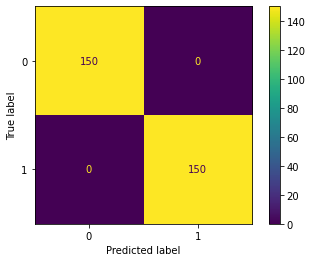

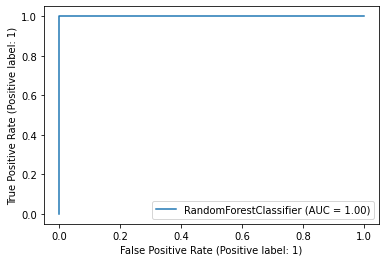

In [14]:
train_predictions=tuned_RF.predict(X_train)
print(classification_report(y_train,train_predictions))
cm = confusion_matrix(y_train, train_predictions, labels=tuned_RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=tuned_RF.classes_)
disp.plot()
plt.show()

RocCurveDisplay.from_estimator(tuned_RF,X_train,y_train)
plt.show()

              precision    recall  f1-score   support

           0       0.63      0.66      0.65        50
           1       0.65      0.62      0.63        50

    accuracy                           0.64       100
   macro avg       0.64      0.64      0.64       100
weighted avg       0.64      0.64      0.64       100



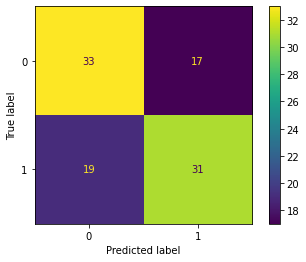

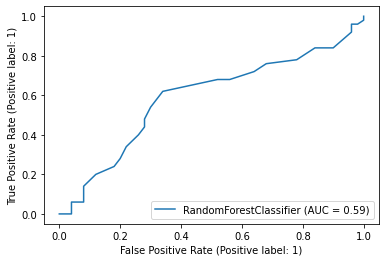

In [15]:
test_predictions=tuned_RF.predict(X_test)
print(classification_report(y_test,test_predictions))
cm = confusion_matrix(y_test, test_predictions, labels=tuned_RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=tuned_RF.classes_)
disp.plot()
plt.show()

RocCurveDisplay.from_estimator(tuned_RF,X_test,y_test)
plt.show()

In [16]:
test_predictions

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [17]:
# #saving as pickle file
# file = open('finalModel.pkl', 'wb')
# pickle.dump(tuned_RF, file)
# file.close()
